## House Pricing - multivariate linear regression - random forest

---

From Kaggle's dataset https://www.kaggle.com/c/house-prices-advanced-regression-techniques the aim is to predict the value of houses.

We will have available:
- train .csv => model will be trained with those data, therefore contains X_train and y_train
- test .csv => contains X_test
- sample submitting data .csv => contains y_test

Important note: So far, mean root squared logarithmic error
- Multivariate linear regression MSRE = 0.118
- Random forest MSRE = 0.1108

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Loading and checking shape of the dataframe
df_train = pd.read_csv('train.csv')
n,m = df_train.shape
print('train rows, n = ', n)
print('train columns, m = ', m)
pd.options.display.max_columns = None
df_train.head()

train rows, n =  1460
train columns, m =  81


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Checking columns that have a NaN value
cols_with_missing = [col for col in df_train.columns if df_train[col].isna().any()]
print(cols_with_missing)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [4]:
# Checking how many NaN values they have in order to treat missing data
df_train[cols_with_missing].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [5]:
# Dropping columns that have too many missing data
train_drop_1 = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']
df_train.drop(columns = train_drop_1, inplace = True)

In [6]:
print(df_train.shape)
df_train.fillna(df_train.median(), inplace = True)
df_train.head()

(1460, 76)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [7]:
# Transforming Categorical features to Numerical
for col_name in df_train.columns:
    if (df_train[col_name].dtype == 'object'):
        df_train[col_name]= df_train[col_name].astype('category')
        df_train[col_name] = df_train[col_name].cat.codes
        
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706,5,0,150,856,1,0,1,4,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,1,2003.0,1,2,548,4,4,2,0,61,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978,5,0,284,1262,1,0,1,4,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,1,1976.0,1,2,460,4,4,2,298,0,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,3,2,2,486,5,0,434,920,1,0,1,4,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,1,2001.0,1,2,608,4,4,2,0,42,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,3,1,3,0,216,5,0,540,756,1,2,1,4,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,5,1998.0,2,3,642,4,4,2,0,35,272,0,0,0,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,3,0,2,655,5,0,490,1145,1,0,1,4,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,1,2000.0,1,3,836,4,4,2,192,84,0,0,0,0,0,12,2008,8,4,250000


In [8]:
cols_with_missing = [col for col in df_train.columns if df_train[col].isna().any()]
print(cols_with_missing)

[]


In [9]:
df_train.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 76, dtype: int64

In [10]:
# We drop highly correlated features
# Create correlation matrix
corr_matrix = df_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df_train.drop(to_drop, axis=1, inplace=True)

In [11]:
print(df_train.shape)
df_train.head()

(1460, 76)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706,5,0,150,856,1,0,1,4,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,1,2003.0,1,2,548,4,4,2,0,61,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978,5,0,284,1262,1,0,1,4,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,1,1976.0,1,2,460,4,4,2,298,0,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,3,2,2,486,5,0,434,920,1,0,1,4,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,1,2001.0,1,2,608,4,4,2,0,42,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,3,1,3,0,216,5,0,540,756,1,2,1,4,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,5,1998.0,2,3,642,4,4,2,0,35,272,0,0,0,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,3,0,2,655,5,0,490,1145,1,0,1,4,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,1,2000.0,1,3,836,4,4,2,192,84,0,0,0,0,0,12,2008,8,4,250000


In [12]:
# Now we want to select main features correlated with dependent variable SalePrice

# Correlation with output variable
corr_matrix = df_train.corr().abs()
corr_matrix_target = abs(corr_matrix["SalePrice"])

# Selecting highly correlated features
relevant_features = corr_matrix_target[corr_matrix_target > 0.4]
relevant_features

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
ExterQual       0.636884
BsmtQual        0.438881
TotalBsmtSF     0.613581
HeatingQC       0.400178
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
KitchenQual     0.589189
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.466754
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [13]:
df_relevant_features = pd.DataFrame(data = relevant_features)
df_train = df_train[df_relevant_features.T.columns]
df_train.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,TotalBsmtSF,HeatingQC,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice
0,7,2003,2003,196.0,2,2,856,0,856,1710,2,2,8,0,2003.0,2,548,208500
1,6,1976,1976,0.0,3,2,1262,0,1262,1262,2,3,6,1,1976.0,2,460,181500
2,7,2001,2002,162.0,2,2,920,0,920,1786,2,2,6,1,2001.0,2,608,223500
3,7,1915,1970,0.0,3,3,756,2,961,1717,1,2,7,1,1998.0,3,642,140000
4,8,2000,2000,350.0,2,2,1145,0,1145,2198,2,2,9,1,2000.0,3,836,250000


In [14]:
df_X_test = pd.read_csv('test.csv')
df_y_test = pd.read_csv('sample_submission.csv')

In [15]:
df_test = pd.merge(df_X_test,df_y_test)
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,169277.052498
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,187758.393989
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,183583.683570
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,179317.477511
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,150730.079977


In [16]:
test_drop_1 = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']
df_test.drop(columns = test_drop_1, inplace = True)

In [17]:
cols_with_missing = [col for col in df_test.columns if df_test[col].isna().any()]
print(cols_with_missing)

['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType']


In [18]:
df_test[cols_with_missing].isna().sum()

MSZoning          4
LotFrontage     227
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       16
MasVnrArea       15
BsmtQual         44
BsmtCond         45
BsmtExposure     44
BsmtFinType1     42
BsmtFinSF1        1
BsmtFinType2     42
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageType       76
GarageYrBlt      78
GarageFinish     78
GarageCars        1
GarageArea        1
GarageQual       78
GarageCond       78
SaleType          1
dtype: int64

In [19]:
df_test.fillna(df_test.median(), inplace = True)

In [20]:
# Transforming all Categorical features to Numerical
for col_name in df_test.columns:
    
    if (df_test[col_name].dtype == 'object'):
        df_test[col_name]= df_test[col_name].astype('category')
        df_test[col_name] = df_test[col_name].cat.codes

df_test = df_test[df_relevant_features.T.columns]

df_test.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,TotalBsmtSF,HeatingQC,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice
0,5,1961,1961,0.0,3,3,882.0,4,896,896,1,3,5,0,1961.0,1.0,730.0,169277.052498
1,6,1958,1958,108.0,3,3,1329.0,4,1329,1329,1,2,6,0,1958.0,1.0,312.0,187758.393989
2,5,1997,1998,0.0,3,2,928.0,2,928,1629,2,3,6,1,1997.0,2.0,482.0,183583.683570
3,6,1998,1998,20.0,3,3,926.0,0,926,1604,2,2,7,1,1998.0,2.0,470.0,179317.477511
4,8,1992,1992,0.0,2,2,1280.0,0,1280,1280,2,2,5,0,1992.0,2.0,506.0,150730.079977


In [21]:
# We save the df_train and df_test dataframes before starting modeling
df_train.to_csv('trainClean.csv')
df_test.to_csv('testClean.csv')

## Modeling multivariate linear regression

In [22]:
# Loading data before modeling
df_train = pd.read_csv('trainClean.csv')
print(df_train.shape)
df_test = pd.read_csv('testClean.csv')
print(df_test.shape)

(1460, 19)
(1459, 19)


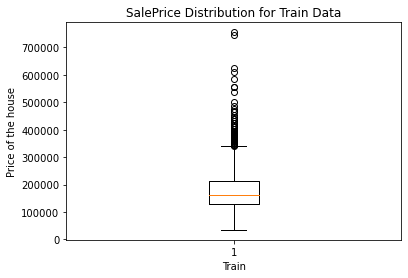

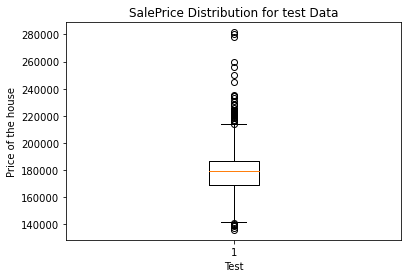

In [23]:
plt.boxplot(df_train['SalePrice']);
plt.title('SalePrice Distribution for Train Data')
plt.xlabel('Train')
plt.ylabel('Price of the house')
plt.show()

plt.boxplot(df_test['SalePrice']);
plt.title('SalePrice Distribution for test Data')
plt.xlabel('Test')
plt.ylabel('Price of the house')
plt.show()

In [24]:
# We train the model with X_train and y_train => before getting values from df_train to have X_train and y_train.

df_train_low_values = df_train[df_train['SalePrice'] <= 350000]
print(df_train_low_values.shape)

# Also normalizing X_train
train_data = df_train_low_values.values
#train_data = df_train.values
X_train = train_data[:,0:df_train.shape[1]-1]
y_train = train_data[:,df_train.shape[1]-1]

# Now fitting model with training data
X_train = StandardScaler().fit(X_train).transform(X_train)
lr = LinearRegression().fit(X_train,y_train)

(1406, 19)


In [25]:
# Using X_test and y_test to check the model

test_data = df_test.values
X_test = test_data[:,0:df_test.shape[1]-1]
y_test = test_data[:,df_test.shape[1]-1]

X_test = StandardScaler().fit(X_test).transform(X_test)
y_hat = lr.predict(X_test)

# Calculating metrics of the model
print('Mean squared error for test data = ', mean_squared_error(y_test,y_hat, squared = True))
print('Mean root squared logarithmic error for test data = ', mean_squared_log_error(y_test,y_hat))

Mean squared error for test data =  3033686298.928827
Mean root squared logarithmic error for test data =  0.11830133432974238


193053.0
131095.0


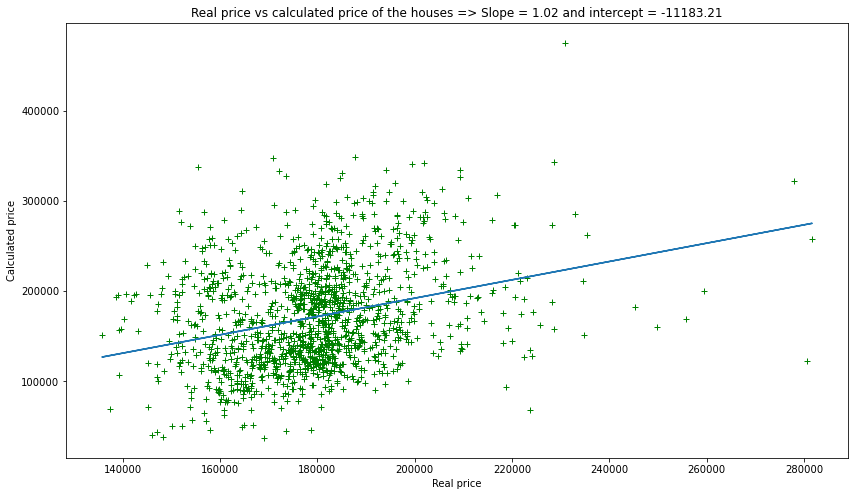

(1459,)
(161,)
Mean difference in price evaluation from the model =  42600.0


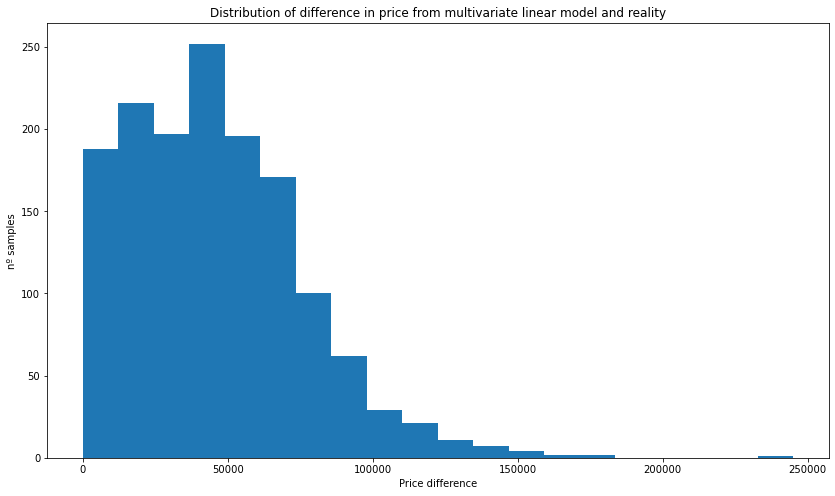

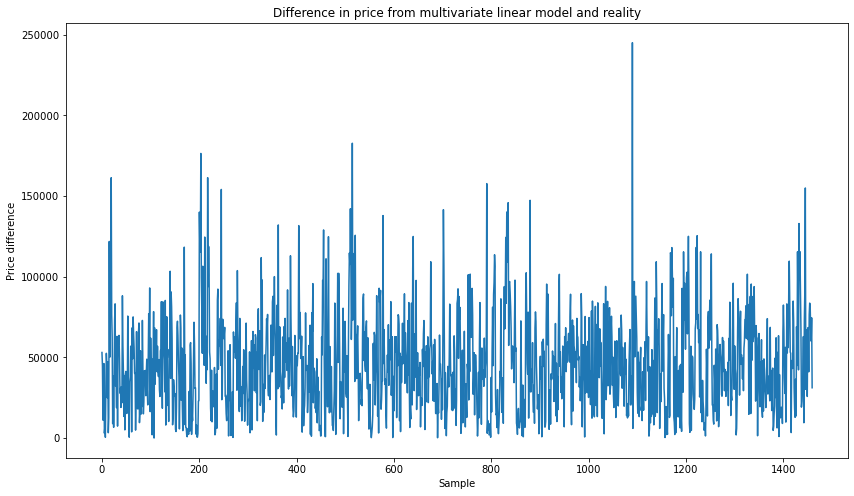

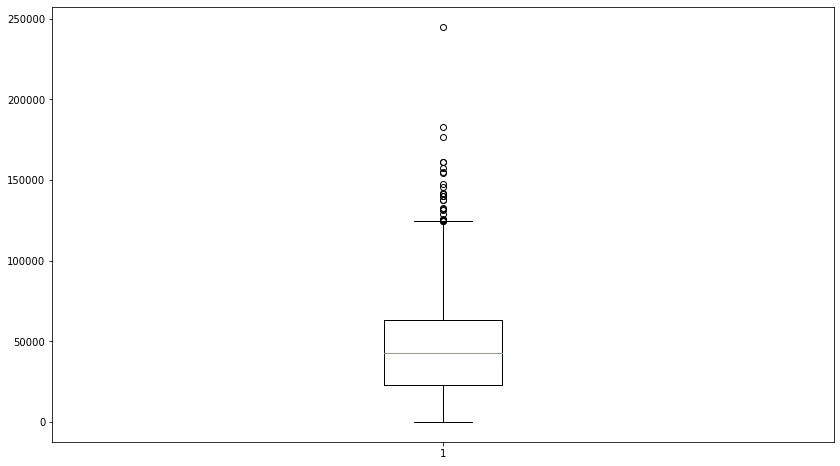

In [26]:
# Checking with some random values of y_test and y_hat if the model is accurate
print(np.round(y_test[100],decimals=0))
print(np.round(y_hat[100],decimals=0))

plt.rcParams['figure.figsize'] = (14,8)
plt.plot(y_test,y_hat,'g+')
m, b = np.polyfit(y_test,y_hat,1)
plt.plot(y_test, m*y_test + b)
plt.title('Real price vs calculated price of the houses => '+'Slope = '+str(np.round(m,decimals = 2))+' and intercept = '
          +str(np.round(b,decimals = 2)))
plt.xlabel('Real price')
plt.ylabel('Calculated price')
plt.show()

# We do some plots to visualize the situation and accuracy of the model
diff = np.absolute(y_test-y_hat)
print(diff.shape)
a = diff[diff <= 10000]
print(a.shape)
print('Mean difference in price evaluation from the model = ', np.median(diff).round(decimals = 0))

plt.rcParams['figure.figsize'] = (14,8)

plt.hist(diff,bins = 20);
plt.title('Distribution of difference in price from multivariate linear model and reality')
plt.xlabel('Price difference')
plt.ylabel('nº samples')
plt.show()

plt.plot(np.linspace(0,y_test.shape[0],y_test.shape[0]),diff);
plt.title('Difference in price from multivariate linear model and reality')
plt.xlabel('Sample')
plt.ylabel('Price difference')
plt.show()

plt.boxplot(diff)
plt.show()

## Random Forest

In [27]:
model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
y_hat_rf = model_rf.predict(X_test)
print('Mean squared error for test data = ', mean_squared_error(y_test,y_hat_rf, squared = True))
print('Mean root squared logarithmic error for test data = ', mean_squared_log_error(y_test,y_hat_rf))

Mean squared error for test data =  3242720225.355043
Mean root squared logarithmic error for test data =  0.11086594996059694


Mean difference in price evaluation from the model =  47648.0


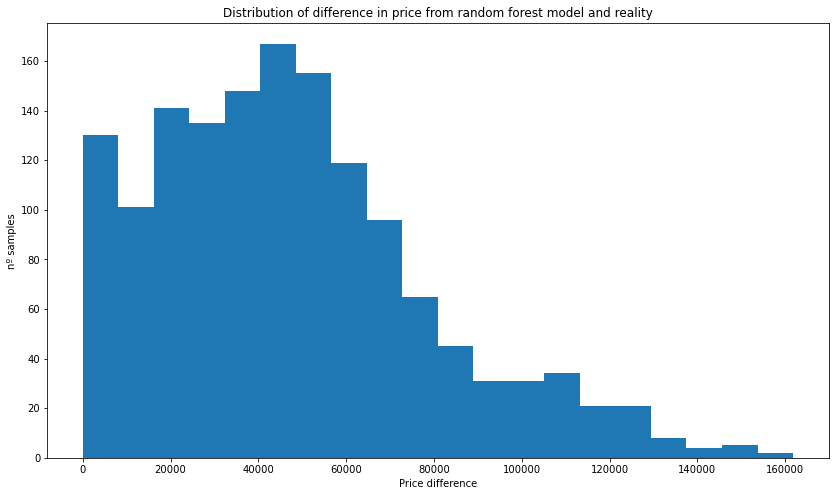

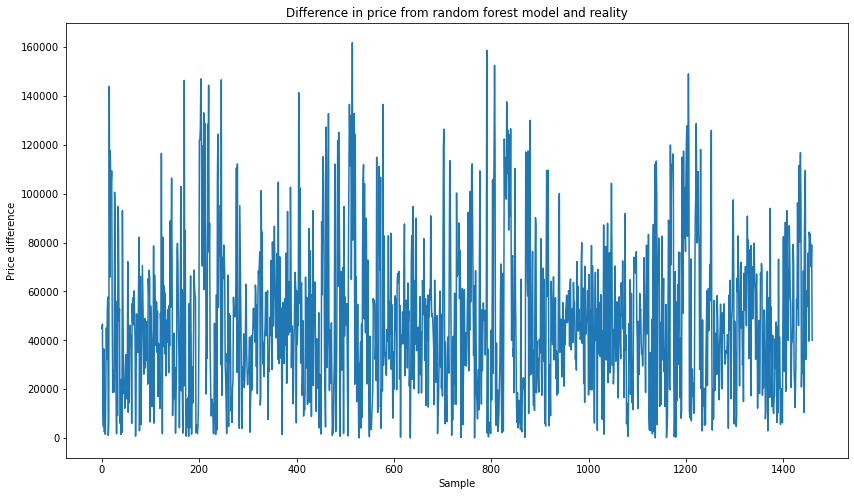

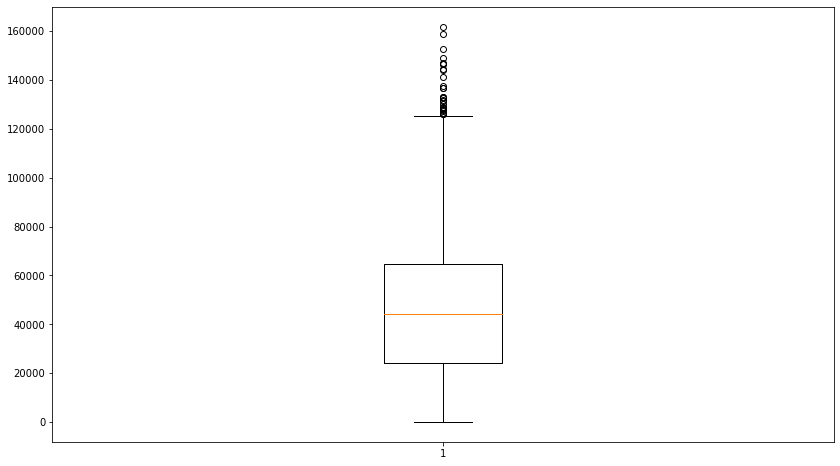

In [28]:
# We do some plots to visualize the situation and accuracy of the model
diff = np.absolute(y_test-y_hat_rf)
print('Mean difference in price evaluation from the model = ', np.mean(diff).round(decimals = 0))

plt.rcParams['figure.figsize'] = (14,8)

plt.hist(diff,bins = 20);
plt.title('Distribution of difference in price from random forest model and reality')
plt.xlabel('Price difference')
plt.ylabel('nº samples')
plt.show()

plt.plot(np.linspace(0,y_test.shape[0],y_test.shape[0]),diff);
plt.title('Difference in price from random forest model and reality')
plt.xlabel('Sample')
plt.ylabel('Price difference')
plt.show()

plt.boxplot(diff)
plt.show()